### ToE analysis for fish (annual), krill (seasonal), emperors (annual), adelies (annual)

#### set up paths

In [1]:
feisty_dir = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-LE-FEISTY'
data_dir = '/glade/derecho/scratch/kristenk/ToE_saved_data'
fig_dir = '/glade/work/kristenk/figs'
mask_dir = '/glade/u/home/kristenk/antarc_marine_pred_work/TOE'
penguin_dir = '/glade/work/kristenk/penguin_data'

In [2]:
import matplotlib.pyplot as plt
import xarray as xr
from distributed import Client
from ncar_jobqueue import NCARCluster
import dask
import numpy as np
import pop_tools
import warnings
warnings.filterwarnings('ignore')
import cartopy
import cartopy.crs as ccrs
import utils
from glob import glob
import numpy as np
import matplotlib.path as mpath
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import cmocean

### Get grid info

In [3]:
ds_grid = pop_tools.get_grid('POP_gx1v7').isel(nlat=slice(0,55))
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
lons_norm = utils.normal_lons(lons)
area_km2 = area * 1e-10

In [4]:
years = np.arange(1920,2101,1)

In [5]:
years = xr.DataArray(years,dims=('time'))

### Make a SIZ mask, so then we can do an area-weighted average for each longitude

In [6]:
ds_siz_mask = xr.open_dataset(f'{mask_dir}/SIZ_mask_1920-50-CESM2LE_15percentJJA.nc')
ds_siz_mask = ds_siz_mask.isel(nlat=slice(0,55))

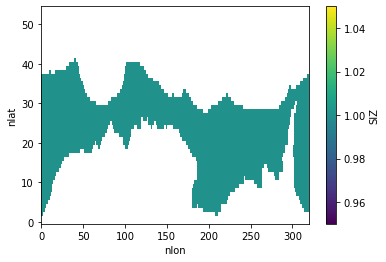

In [7]:
ds_siz_mask.SIZ.plot()

In [8]:
ones = np.full((55,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

In [9]:
siz_mask = ds_siz_mask.SIZ

### get fish data

In [9]:
file = f'{data_dir}/FEISTY_ann_tot_fish.nc'
ds_fish = xr.open_dataset(file)
ds_fish = ds_fish.isel(nlat=slice(0,55))
ds_fish = ds_fish.isel(time=slice(70,250))
ds_fish

<xarray.Dataset>
Dimensions:             (fish: 8, group: 9, member_id: 50, nlat: 55, nlon: 320, time: 180)
Coordinates:
  * fish                (fish) object 'Sf' 'Sp' 'Sd' 'Mf' 'Mp' 'Md' 'Lp' 'Ld'
  * group               (group) object 'Sf' 'Sp' 'Sd' ... 'Ld' 'benthic_prey'
  * nlat                (nlat) int64 0 1 2 3 4 5 6 7 ... 47 48 49 50 51 52 53 54
  * nlon                (nlon) int64 0 1 2 3 4 5 6 ... 314 315 316 317 318 319
  * time                (time) int64 1920 1921 1922 1923 ... 2096 2097 2098 2099
Dimensions without coordinates: member_id
Data variables:
    total_forage        (member_id, time, nlat, nlon) float64 ...
    total_pelagic       (member_id, time, nlat, nlon) float64 ...
    total_demersal      (member_id, time, nlat, nlon) float64 ...
    total_fish          (member_id, time, nlat, nlon) float64 ...
    total_forage_ice    (member_id, time, nlat, nlon) float64 ...
    total_pelagic_ice   (member_id, time, nlat, nlon) float64 ...
    total_demersal_ice  (member_id, time, nlat, nlon) float64 ...
    total_fish_ice      (member_id, time, nlat, nlon) float64 ...

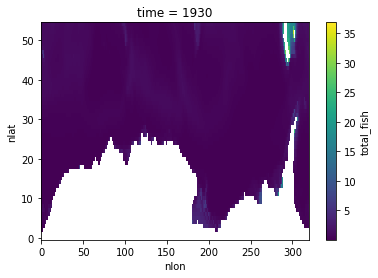

In [10]:
ds_fish.total_fish.isel(member_id=24).isel(time=10).plot()

In [11]:
#### Mask out places that have very little fish biomass during the base period (and not much afterwards either)

ds_fish_start = ds_fish.isel(time=slice(0,30)).mean(dim=('time','member_id')).load()
ds_fish_end = ds_fish.isel(time=slice(150,180)).mean(dim=('time','member_id')).load()

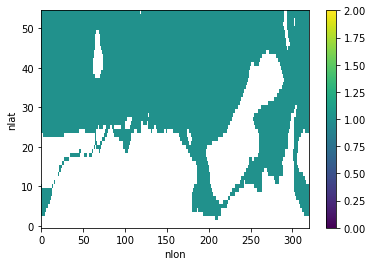

In [12]:
thres_totfish = ones.where(ds_fish_start.total_fish>0.05) #.where(ds_fish_end.total_fish>0.05)
thres_totfish.plot(vmin=0,vmax=2)

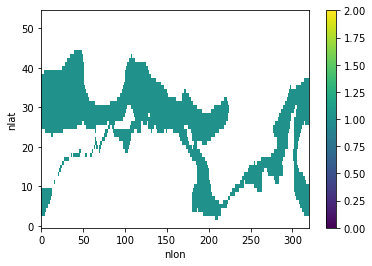

In [13]:
thres_icefish = ones.where(ds_fish_start.total_fish_ice>0.05) #.where(ds_fish_end.total_fish_ice>0.05)
thres_icefish.plot(vmin=0,vmax=2)

In [14]:
ds_fish['total_fish'] = ds_fish['total_fish'].where(thres_totfish > 0)
ds_fish['total_fish_ice'] = ds_fish['total_fish_ice'].where(thres_icefish > 0)

### get krill growth data

In [18]:
file = f'{data_dir}/CESM2-LE-seasonal-integrals-KGP.nc'
ds_kgp = xr.open_dataset(file)
ds_kgp = ds_kgp.isel(nlat=slice(0,55))
ds_kgp = ds_kgp.isel(time=slice(70,250))
ds_kgp

<xarray.Dataset>
Dimensions:     (member_id: 50, nlat: 55, nlon: 320, time: 180)
Coordinates:
  * time        (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    KGP_ONDJFM  (time, member_id, nlat, nlon) float64 ...
    KGP_OND     (time, member_id, nlat, nlon) float64 ...
    KGP_JFM     (time, member_id, nlat, nlon) float64 ...
Attributes:
    author:          Kristen Krumhardt
    date_processed:  2024-01-23
    contents:        yearly KGP in the Southern Ocean from 1850 to 2099. Each...

In [19]:
#### mask out placse in the KGP dataset that are:
### 1) outside of the SIZ
### 2) less than one (these = 0)
### 3) KGP during base period too low to reliably estimate standard deviation and therefore ToE


ds_kgp = ds_kgp.where(ds_siz_mask.SIZ ==1)

In [20]:
for var in ['KGP_ONDJFM','KGP_OND','KGP_JFM']:
    ds_kgp[var] = ds_kgp[var].where(ds_kgp[var] >= 0, other=0).where(ds_grid.REGION_MASK >0)

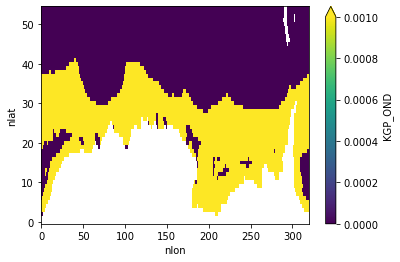

In [21]:
ds_kgp.KGP_OND.isel(time=slice(0,30)).mean(dim=('time','member_id')).plot(vmin=0,vmax=0.001)

In [22]:
basep_kgp_ond = ds_kgp.KGP_OND.isel(time=slice(0,30)).mean(dim=('time','member_id'))
basep_kgp_jfm = ds_kgp.KGP_JFM.isel(time=slice(0,30)).mean(dim=('time','member_id'))

In [23]:
endc_kgp_ond = ds_kgp.KGP_OND.isel(time=slice(170,180)).mean(dim=('time','member_id'))
endc_kgp_jfm = ds_kgp.KGP_JFM.isel(time=slice(170,180)).mean(dim=('time','member_id'))

In [24]:
ds_kgp['KGP_OND'] = ds_kgp.KGP_OND.where(basep_kgp_ond > 0.001) #.where(endc_kgp_ond > 0.001)

In [25]:
ds_kgp['KGP_JFM'] = ds_kgp.KGP_JFM.where(basep_kgp_jfm > 0.001) .where(endc_kgp_ond > 0.001)

### Put all these together into one dataset

In [26]:
ds = xr.Dataset()
ds['total_fish'] = ds_fish.total_fish
ds['total_ice_fish'] = ds_fish.total_fish_ice
ds['KGP_JFM'] = ds_kgp.KGP_JFM
ds['KGP_OND'] = ds_kgp.KGP_OND

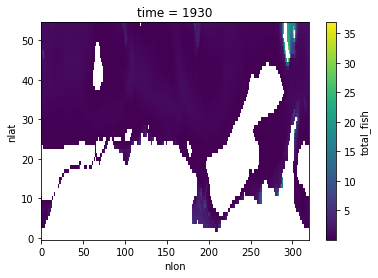

In [27]:
ds.total_fish.isel(member_id=24).isel(time=10).plot()

### get emperor penguin ToE data

In [28]:
import pandas as pd

In [29]:
file = f'{penguin_dir}/Emperor_ToE_dataset.csv'
df_toe_emp = pd.read_csv(file)
#df_toe_emp['mean_toe'] = df_toe_emp[['NoE1u','EXTh1u','EXTi1u','NoE1','EXTh1','EXTi1']].mean(axis=1)

In [30]:
df_toe_emp

,site_id,site_name,latitude,longitude,new #,ToE
0,SNOW,Snow Hill Island,-64.5238,-57.4445,1,2014
1,JASN,Jason Peninsula,-66.0996,-60.6737,2,2021
2,DOLL,Dolleman,-70.6106,-60.4207,3,2031
3,SMTH,Smith,-74.3693,-60.8273,4,2069
4,GOUL,Gould,-77.7099,-47.6562,5,2072
...,...,...,...,...,...,...
61,SMYL,Smyley,-72.3017,-78.8195,62,2021
62,VERD,Verdi Inlet,-71.5559,-74.7603,63,2021
63,ROTS,Rothschild Island,-69.5209,-72.2293,64,2021
64,DION,Emperor Island,-67.8647,-68.7100,65,2028


#### get Adelie penguin data

In [31]:
file = f'{penguin_dir}/ToE_AdelieFinal_4import.csv'
df_toe_adel = pd.read_csv(file)
df_toe_adel #.iloc[151]

,Unnamed: 0,site_id,site_name,latitude,longitude,longetidtude 2,Toe trend 1950-2025,Toe trend 2025-2050,Toe trend 2075-2100,Trend 1950-2025,Trend 2025-2050,Trend 2075-2100,ToE-to-use,direction
0,1,ACUN,Acuna Island,-60.7612,-44.6370,315.3630,2070.0,2070.0,2070.0,-0.0002,-0.0003,-0.0001,2070,-1
1,2,ADAM,Adams Island,-66.5459,92.5486,92.5486,2014.0,2014.0,2014.0,-0.0001,-0.0006,-0.0016,2014,-1
2,3,ADAR,Cape Adare,-71.3063,170.1999,170.1999,NaN,NaN,NaN,0.0002,0.0001,0.0000,0,0
3,4,AKAR,Akarui Point,-68.4999,41.3901,41.3901,1998.0,1998.0,1998.0,-0.0003,-0.0007,-0.0001,1998,-1
4,5,ALAS,Alasheyev Bight,-67.6540,46.1090,46.1090,1998.0,1998.0,1998.0,-0.0004,-0.0007,-0.0001,1998,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,283,WTAY,West of Tay Head,-63.3340,-55.6430,304.3570,2040.0,2040.0,2040.0,-0.0002,-0.0003,-0.0004,2040,-1
283,284,WYAT,Wyatt Earp Islands,-68.3569,78.5385,78.5385,NaN,2074.0,2074.0,0.0000,-0.0001,-0.0005,2074,-1
284,285,YALO,Yalour Islands,-65.2389,-64.1564,295.8436,NaN,NaN,NaN,-0.0003,-0.0004,0.0000,0,0
285,286,YOUN,Young Island,-66.4167,162.4000,162.4000,2023.0,2023.0,2023.0,-0.0001,-0.0002,-0.0006,2023,-1


In [32]:
df_toe_adel_positive = df_toe_adel[(df_toe_adel['direction']>0)]
df_toe_adel_positive

,Unnamed: 0,site_id,site_name,latitude,longitude,longetidtude 2,Toe trend 1950-2025,Toe trend 2025-2050,Toe trend 2075-2100,Trend 1950-2025,Trend 2025-2050,Trend 2075-2100,ToE-to-use,direction
10,11,ANNE,Cape Anne,-73.617000,169.850000,169.850000,2091.0,2091.0,2091.0,0.0002,0.0002,0.0002,2091,1
16,17,BACK,Backer Islands,-74.411200,-102.551500,257.448500,2044.0,2044.0,NaN,0.0003,0.0006,-0.0020,2044,1
21,22,BEAN,Beaufort Island North,-76.928800,166.881000,166.881000,2090.0,2090.0,2090.0,0.0002,0.0001,0.0002,2090,1
22,23,BEAU,Beaufort Island,-76.969400,166.897800,166.897800,2086.0,2086.0,2086.0,0.0001,0.0001,0.0002,2086,1
35,36,BRDM,Cape Bird Middle,-77.230393,166.418700,166.418700,2086.0,2086.0,2086.0,0.0001,0.0001,0.0002,2086,1
36,37,BRDN,Cape Bird North,-77.214483,166.445890,166.445890,2086.0,2086.0,2086.0,0.0001,0.0001,0.0002,2086,1
37,38,BRDS,Cape Bird South,-77.259444,166.379444,166.379444,2086.0,2086.0,2086.0,0.0001,0.0001,0.0002,2086,1
39,40,BSON,Brownson Islands,-74.140000,-103.480000,256.520000,2044.0,2044.0,NaN,0.0003,0.0005,-0.0023,2044,1
40,41,BURK,Cape Burks,-74.750466,-136.829586,223.170414,2055.0,2055.0,NaN,0.0004,0.0006,-0.0016,2055,1
41,42,CBAR,Cape Barne,-77.578012,166.241620,166.241620,2076.0,2076.0,2076.0,0.0001,0.0001,0.0002,2076,1


In [33]:
df_toe_adel_negative = df_toe_adel[(df_toe_adel['direction']<0)]
df_toe_adel_negative

,Unnamed: 0,site_id,site_name,latitude,longitude,longetidtude 2,Toe trend 1950-2025,Toe trend 2025-2050,Toe trend 2075-2100,Trend 1950-2025,Trend 2025-2050,Trend 2075-2100,ToE-to-use,direction
0,1,ACUN,Acuna Island,-60.7612,-44.6370,315.3630,2070.0,2070.0,2070.0,-0.0002,-0.0003,-0.0001,2070,-1
1,2,ADAM,Adams Island,-66.5459,92.5486,92.5486,2014.0,2014.0,2014.0,-0.0001,-0.0006,-0.0016,2014,-1
3,4,AKAR,Akarui Point,-68.4999,41.3901,41.3901,1998.0,1998.0,1998.0,-0.0003,-0.0007,-0.0001,1998,-1
4,5,ALAS,Alasheyev Bight,-67.6540,46.1090,46.1090,1998.0,1998.0,1998.0,-0.0004,-0.0007,-0.0001,1998,-1
5,6,AMPH,Amphibolite Point,-60.6840,-45.3390,314.6610,2075.0,2075.0,2075.0,-0.0002,-0.0002,-0.0001,2075,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,282,WPEC,Watson Peninsula (east coast),-60.6761,-44.5436,315.4564,2078.0,2078.0,2078.0,-0.0002,-0.0002,-0.0001,2078,-1
282,283,WTAY,West of Tay Head,-63.3340,-55.6430,304.3570,2040.0,2040.0,2040.0,-0.0002,-0.0003,-0.0004,2040,-1
283,284,WYAT,Wyatt Earp Islands,-68.3569,78.5385,78.5385,NaN,2074.0,2074.0,0.0000,-0.0001,-0.0005,2074,-1
285,286,YOUN,Young Island,-66.4167,162.4000,162.4000,2023.0,2023.0,2023.0,-0.0001,-0.0002,-0.0006,2023,-1


In [34]:
df_toe_adel_noToE = df_toe_adel[(df_toe_adel['direction']==0)]
df_toe_adel_noToE

,Unnamed: 0,site_id,site_name,latitude,longitude,longetidtude 2,Toe trend 1950-2025,Toe trend 2025-2050,Toe trend 2075-2100,Trend 1950-2025,Trend 2025-2050,Trend 2075-2100,ToE-to-use,direction
2,3,ADAR,Cape Adare,-71.306300,170.199900,170.199900,NaN,NaN,NaN,0.0002,0.0001,0.0000,0,0
13,14,ARTH,Arthurson Ridge,-69.363400,158.510900,158.510900,NaN,NaN,NaN,0.0001,0.0000,-0.0005,0,0
26,27,BERT,Berthelot Islands (excl. Green Island),-65.333000,-64.112000,295.888000,NaN,NaN,NaN,-0.0003,-0.0004,0.0000,0,0
44,45,CHAL,Cape Hallett,-72.317900,170.214200,170.214200,NaN,NaN,NaN,0.0002,0.0002,0.0002,0,0
53,54,CHIS,Christine Island,-64.794600,-64.023600,295.976400,NaN,NaN,NaN,-0.0003,-0.0003,0.0000,0,0
62,63,CONI,Conical Island (Aviation Islands),-69.274761,158.779817,158.779817,NaN,NaN,NaN,0.0001,0.0000,-0.0005,0,0
63,64,CORM,Cormorant Island,-64.793900,-63.966700,296.033300,NaN,NaN,NaN,-0.0003,-0.0003,0.0000,0,0
65,66,COTT,Cape Cotter,-72.404500,170.312200,170.312200,NaN,NaN,NaN,0.0002,0.0002,0.0002,0,0
78,79,DOME,Dome Island (Aviation Islands),-69.274761,158.779817,158.779817,NaN,NaN,NaN,0.0001,0.0000,-0.0005,0,0
81,82,DOWN,Downshire Cliffs,-71.558200,170.592000,170.592000,NaN,NaN,NaN,0.0002,0.0001,0.0001,0,0


In [35]:
print('Adelie colonies with increasing ToE value = ', len(df_toe_adel_positive))

Adelie colonies with increasing ToE value =  27


In [36]:
print('Adelie colonies with decreasing ToE value = ', len(df_toe_adel_negative))

Adelie colonies with decreasing ToE value =  217


In [37]:
print('Adelie colonies with no ToE = ', len(df_toe_adel_noToE))

Adelie colonies with no ToE =  43


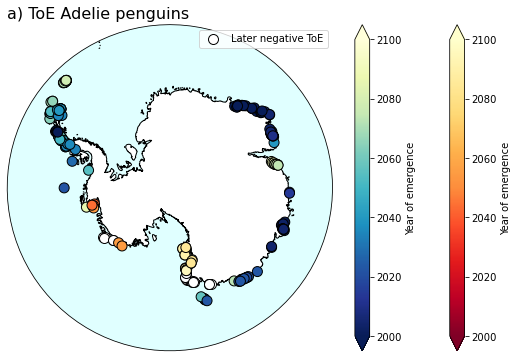

In [38]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('a) ToE Adelie penguins',loc='left',fontsize=16)
ax.set_extent([-180, 180, -90, -58], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1,zorder=1)

sc_p = ax.scatter(df_toe_adel_positive.longitude,df_toe_adel_positive.latitude, c=df_toe_adel_positive['ToE-to-use'], vmin=2000, vmax =2100, cmap='YlOrRd_r', s=100, 
                edgecolors='black', zorder=4,transform=ccrs.PlateCarree())

sc_n = ax.scatter(df_toe_adel_negative.longitude,df_toe_adel_negative.latitude, c=df_toe_adel_negative['ToE-to-use'], vmin=2000, vmax =2100, cmap='YlGnBu_r', s=100, 
                edgecolors='black', zorder=3,transform=ccrs.PlateCarree())

sc_pn = ax.scatter(df_toe_adel_noToE.longitude,df_toe_adel_noToE.latitude, s=100, zorder=2, color='white', edgecolor='black', transform=ccrs.PlateCarree(),label='Later negative ToE')

ax.add_feature(cfeature.OCEAN, facecolor='lightcyan',zorder=0)
ax.legend()
#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle
cbar = fig.colorbar(sc_p, ax=ax,extend='both',label='Year of emergence')
cbar = fig.colorbar(sc_n, ax=ax,extend='both',label='Year of emergence')

### Calculate ToE of seasonal sums/means

In [39]:
time3d = np.full([180,55,320],1,dtype=int)

In [40]:
ylen = 55
xlen = 320

for x in np.arange(0,xlen,1):
    for y in np.arange(0,ylen,1):

        time3d[:,y,x]=ds.time.values

time3d = xr.DataArray(time3d,dims=('time','nlat','nlon'))

#### calculate up/low thresholds for fish and krill

In [46]:
%%time

# #### empty dictionaries, keys are variable names
upthres_ds = xr.Dataset()
lothres_ds = xr.Dataset()

variables=['total_fish','total_ice_fish','KGP_JFM','KGP_OND']

for var in variables:
    
    ### calculate                                                                                                                                                                                                                                                                 
    mean_var = ds[var].isel(time=slice(0,30)).mean(dim=('time','member_id'))
    std_var = ds[var].isel(time=slice(0,30)).std(dim=('member_id','time'))
    
    var_array_upthres = mean_var + 2 * std_var
    var_array_lothres = mean_var - 2 * std_var

    upthres_ds[var] = var_array_upthres
    lothres_ds[var] = var_array_lothres

CPU times: user 582 ms, sys: 127 ms, total: 709 ms
Wall time: 731 ms


In [47]:
ToE_up_icefish = time3d.where(ds.total_ice_fish.mean(dim='member_id') > upthres_ds['total_ice_fish'])
ToE_up_icefish = ToE_up_icefish.min(dim='time')

In [48]:
ToE_down_icefish = time3d.where(ds.total_ice_fish.mean(dim='member_id') < lothres_ds['total_ice_fish'])
ToE_down_icefish = ToE_down_icefish.min(dim='time')

In [49]:
ToE_up_fish = time3d.where(ds.total_fish.mean(dim='member_id') > upthres_ds['total_fish'])
ToE_up_fish = ToE_up_fish.min(dim='time')

In [50]:
ToE_down_fish = time3d.where(ds.total_fish.mean(dim='member_id') < lothres_ds['total_fish'])
ToE_down_fish = ToE_down_fish.min(dim='time')

In [52]:
ToE_up_kgp_ond = time3d.where(ds.KGP_OND.mean(dim='member_id') > upthres_ds['KGP_OND'])
ToE_up_kgp_ond = ToE_up_kgp_ond.min(dim='time')

ToE_up_kgp_jfm = time3d.where(ds.KGP_JFM.mean(dim='member_id') > upthres_ds['KGP_JFM'])
ToE_up_kgp_jfm = ToE_up_kgp_jfm.min(dim='time')

In [53]:
ToE_down_kgp_ond = time3d.where(ds.KGP_OND.mean(dim='member_id') < lothres_ds['KGP_OND'])
ToE_down_kgp_ond = ToE_down_kgp_ond.min(dim='time')

ToE_down_kgp_jfm = time3d.where(ds.KGP_JFM.mean(dim='member_id') < lothres_ds['KGP_JFM'])
ToE_down_kgp_jfm = ToE_down_kgp_jfm.min(dim='time')

### Make some line plots to go with the maps

In [54]:
ts_SIZ = xr.Dataset()

v ='total_fish'
        
######## Whole SIZ
masked_area = area.where(ds_siz_mask.SIZ==1)
masked_area['nlat'] = ds_siz_mask.SIZ.nlat
masked_area['nlon'] = ds_siz_mask.SIZ.nlon

masked_fosi = ds[v].where(ds_siz_mask.SIZ==1)

ts_SIZ[v] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

v ='total_ice_fish'
        
######## Whole SIZ
masked_area = area.where(ds_siz_mask.SIZ==1)
masked_area['nlat'] = ds_siz_mask.SIZ.nlat
masked_area['nlon'] = ds_siz_mask.SIZ.nlon

masked_fosi = ds[v].where(ds_siz_mask.SIZ==1)

ts_SIZ[v] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

for v in ['KGP_OND','KGP_JFM']:
        
    ######## Whole SIZ
    masked_area = area.where(ds_siz_mask.SIZ==1)
    masked_area['nlat'] = ds_siz_mask.SIZ.nlat
    masked_area['nlon'] = ds_siz_mask.SIZ.nlon
    
    masked_fosi = ds[v].where(ds_siz_mask.SIZ==1)
    
    ts_SIZ[v] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

In [55]:
for mem in np.arange(0,50,1):

    print (mem, np.min(ts_SIZ.total_fish.isel(member_id=mem, time=slice(0,30)).values))

0 0.36767221165618263
1 0.37964071112328734
2 0.38069680839750136
3 0.3776609007739957
4 0.3747028458319108
5 0.3804517716014062
6 0.36861518156748024
7 0.37955900894339095
8 0.37813996812764444
9 0.3854002261253521
10 0.3860006297216492
11 0.37516777875343926
12 0.37516777875343926
13 0.3594675036521137
14 0.36199646175330485
15 0.35874576998881075
16 0.37648269830533354
17 0.3718329283060396
18 0.37648269830533354
19 0.37648269830533354
20 0.3718536293517458
21 0.37241350273002055
22 0.3895910220937662
23 0.38977682896189547
24 0.38977682896189547
25 0.3854932453971727
26 0.3854932453971727
27 0.3854932453971727
28 0.38611834342368934
29 0.3869141643628088
30 0.38397060386581966
31 0.3866196198191548
32 0.3839336646191406
33 0.3839336646191406
34 0.3839336646191406
35 0.3844329012161128
36 0.3835194376166051
37 0.38462500670354277
38 0.38462500670354277
39 0.38423890900679625
40 0.35425786483609417
41 0.3557545854988502
42 0.3540486155257105
43 0.3541988359958171
44 0.355859997425948

### READ IN penguin circumpolar timeseries here

In [56]:
### get the circumpolar data
adelie_dict = {}
adel_regs = ['AP','Adelie','Ross','AmBel','Prydz','SIZ']
adel_years = np.arange(1920,2101,1)
sims = np.arange(1,51,1)
file = '/glade/work/kristenk/penguin_data/Adelie_data2/r_cpolar_adpe.csv'
df_adel_reg = pd.read_csv(file,header=None)
df_adel_reg = df_adel_reg.T #transpose data file
# df_adel_reg['mean']= df_adel_reg[sims].mean(axis=1)
## transform out of log space
df_adel_reg[sims] = 10**(df_adel_reg[sims])
adelie_dict[adel_regs[5]] = xr.DataArray(df_adel_reg[sims],dims=('time','sim')).isel(time=slice(20,202))
adelie_dict[adel_regs[5]]['time'] = adel_years

In [57]:
file = '/glade/work/kristenk/penguin_data/Emperor_data_regions2/R_globalKK3_7.csv'
df_emp_reg = pd.read_csv(file,header=None)

In [58]:
emperor_dict = {}
emperor_dict['SIZ'] = xr.DataArray(df_emp_reg,dims=('time','sim'))
emperor_dict['SIZ']['time'] = adel_years

### Determine time of emergence for all Adelies and Emperors

In [59]:
adelie_dict['SIZ']

<xarray.DataArray (time: 181, sim: 50)>
array([[0.91792503, 0.92228944, 0.95206375, ..., 0.94048872, 0.95693322,
        0.93635773],
       [0.94770448, 0.93615187, 0.92775678, ..., 0.97385871, 0.92816364,
        0.95531905],
       [0.98107444, 0.93321076, 0.93097284, ..., 0.95708471, 0.95810231,
        0.93308257],
       ...,
       [1.05959345, 1.07297424, 1.0661075 , ..., 1.07088887, 1.0633788 ,
        1.05536974],
       [1.07081725, 1.06162969, 1.06632788, ..., 1.05678935, 1.0618647 ,
        1.05757046],
       [1.0659459 , 1.05969503, 1.07194222, ..., 1.0590368 , 1.06413079,
        1.06647644]])
Coordinates:
  * time     (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099 2100
  * sim      (sim) int64 1 2 3 4 5 6 7 8 9 10 ... 41 42 43 44 45 46 47 48 49 50

In [60]:
emperor_dict['SIZ']

<xarray.DataArray (time: 181, sim: 50)>
array([[1.01979382, 1.02205507, 1.02242657, ..., 1.02417494, 1.02466292,
        1.02245332],
       [1.0226513 , 1.01994627, 1.02271361, ..., 1.02226992, 1.02110678,
        1.02406192],
       [1.02085416, 1.02488399, 1.02240803, ..., 1.02275038, 1.02290185,
        1.02150283],
       ...,
       [0.99205833, 0.99141158, 0.98759834, ..., 0.99119267, 0.9959882 ,
        0.98805587],
       [0.9871687 , 0.99710084, 1.00488274, ..., 0.99583074, 0.98988367,
        0.97970776],
       [0.99284599, 0.98940122, 0.99073317, ..., 1.00227701, 0.99866456,
        1.0010031 ]])
Coordinates:
  * time     (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099 2100
  * sim      (sim) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49

In [62]:
########### Find ToE of these variables, calculate both increased and decreased ToE and take minimum
ToE_SIZ = xr.Dataset()
ToEval_SIZ = xr.Dataset()
basemean_SIZ = xr.Dataset()

for var in ['total_fish','total_ice_fish','KGP_OND','KGP_JFM']:

    print(var)
    
    #SIZ
    mean = ts_SIZ[var].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
    std = ts_SIZ[var].isel(time=slice(0,30)).std(dim=('time','member_id')).values
    up = ts_SIZ[var]['time'].where(ts_SIZ[var].mean(dim='member_id') > mean+2*std).min(dim='time')
    down = ts_SIZ[var]['time'].where(ts_SIZ[var].mean(dim='member_id') < mean-2*std).min(dim='time')
    ToE_SIZ[var] = np.nanmin([up.values, down.values])
    if not np.isnan(ToE_SIZ[var]):
        ToEval_SIZ[var] = ts_SIZ[var].sel(time=int(ToE_SIZ[var].values)).mean(dim='member_id').values
    else:
        ToEval_SIZ[var] = np.nan
    basemean_SIZ[var] = mean


total_fish
total_ice_fish
KGP_OND
KGP_JFM


In [63]:
mean = adelie_dict['SIZ'].isel(time=slice(0,30)).mean(dim=('time','sim')).values
std = adelie_dict['SIZ'].isel(time=slice(0,30)).std(dim=('time','sim')).values
up = adelie_dict['SIZ']['time'].where(adelie_dict['SIZ'].mean(dim='sim') > mean+2*std).min(dim='time')
down = adelie_dict['SIZ']['time'].where(adelie_dict['SIZ'].mean(dim='sim') < mean-2*std).min(dim='time')
ToE_SIZ['adelie'] = np.nanmin([up.values, down.values])
if not np.isnan(ToE_SIZ['adelie']):
    ToEval_SIZ['adelie'] = adelie_dict['SIZ'].sel(time=int(ToE_SIZ['adelie'].values)).mean(dim='sim').values
else:
    ToEval_SIZ['adelie'] = np.nan
basemean_SIZ['adelie'] = mean

In [64]:
mean = emperor_dict['SIZ'].isel(time=slice(0,30)).mean(dim=('time','sim')).values
std = emperor_dict['SIZ'].isel(time=slice(0,30)).std(dim=('time','sim')).values
up = emperor_dict['SIZ']['time'].where(emperor_dict['SIZ'].mean(dim='sim') > mean+2*std).min(dim='time')
down = emperor_dict['SIZ']['time'].where(emperor_dict['SIZ'].mean(dim='sim') < mean-2*std).min(dim='time')
ToE_SIZ['emperor'] = np.nanmin([up.values, down.values])
if not np.isnan(ToE_SIZ['emperor']):
    ToEval_SIZ['emperor'] = emperor_dict['SIZ'].sel(time=int(ToE_SIZ['emperor'].values)).mean(dim='sim').values
else:
    ToEval_SIZ['emperor'] = np.nan
basemean_SIZ['emperor'] = mean

### Line plots of fish, krill, and penguins

In [65]:
years = np.arange(1920,2100,1)

In [66]:
ts_SIZ

<xarray.Dataset>
Dimensions:         (member_id: 50, time: 180)
Coordinates:
  * time            (time) int64 1920 1921 1922 1923 ... 2096 2097 2098 2099
Dimensions without coordinates: member_id
Data variables:
    total_fish      (member_id, time) float64 0.3991 0.405 ... 0.7115 0.7214
    total_ice_fish  (member_id, time) float64 0.2103 0.2212 ... 0.1835 0.1817
    KGP_OND         (time, member_id) float64 1.973 1.768 2.195 ... 5.926 6.662
    KGP_JFM         (time, member_id) float64 5.614 6.068 5.311 ... 2.52 2.88

### Old figure S9

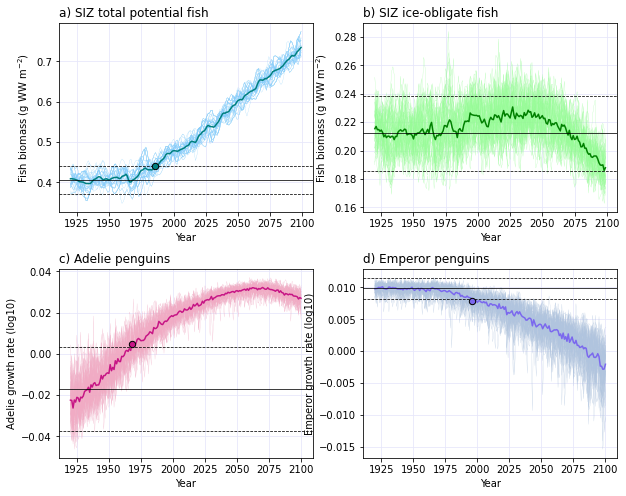

In [67]:
fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(2, 2, 1)
ax.set_title("a) SIZ total potential fish", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax.plot(years, ts_SIZ['total_fish'].isel(member_id=mem), color='lightskyblue',linewidth=0.2)
ax.plot(years, ts_SIZ['total_fish'].mean(dim='member_id'),
           color='teal', zorder=2)
mean = ts_SIZ['total_fish'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ['total_fish'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
ax.axhline(mean, color='black',linewidth=0.75)
ax.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax.scatter(ToE_SIZ.total_fish,ToEval_SIZ.total_fish,s=40,color='teal',edgecolor='black',zorder=3)
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.set_xlabel("Year")
ax.set_ylabel("Fish biomass (g WW m$^{-2}$)")
#######################

ax = fig.add_subplot(2, 2, 2)
ax.set_title("b) SIZ ice-obligate fish", loc="left", fontsize=12)
for mem in np.arange(0,50,1):

    ax.plot(years, ts_SIZ['total_ice_fish'].isel(member_id=mem), color='palegreen',linewidth=0.2)
    
ax.plot(years, ts_SIZ['total_ice_fish'].mean(dim='member_id'),
           color='green', zorder=2)
mean = ts_SIZ['total_ice_fish'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ['total_ice_fish'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
ax.axhline(mean, color='black',linewidth=0.75)
ax.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax.scatter(ToE_SIZ.total_ice_fish,ToEval_SIZ.total_ice_fish,s=40,color='green',edgecolor='black',zorder=3)
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.set_xlabel("Year")
ax.set_ylabel("Fish biomass (g WW m$^{-2}$)")

############# Adelies

ax = fig.add_subplot(2, 2, 3)
ax.set_title("c) Adelie penguins", loc="left", fontsize=12)

for mem in np.arange(0,50,1):

    ax.plot(adelie_dict['SIZ'].time, np.log10(adelie_dict['SIZ'].isel(sim=mem)), color=(240/255,171/255,196/255),linewidth=0.2)
    
ax.plot(adelie_dict['SIZ'].time, np.log10(adelie_dict['SIZ'].mean(dim='sim')),
           color='mediumvioletred', zorder=2)
mean = np.log10(adelie_dict['SIZ'].isel(time=slice(0,30)).mean(dim=('time','sim')).values)
std = np.log10(adelie_dict['SIZ'].isel(time=slice(0,30))).std(dim=('time','sim')).values
ax.axhline(mean, color='black',linewidth=0.75)
ax.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax.scatter(ToE_SIZ.adelie,np.log10(ToEval_SIZ.adelie),s=40,color='mediumvioletred',edgecolor='black',zorder=3)
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.set_xlabel("Year")
ax.set_ylabel("Adelie growth rate (log10)")
############# Emperor - placeholder

ax = fig.add_subplot(2, 2, 4)
ax.set_title("d) Emperor penguins", loc="left", fontsize=12)

for mem in np.arange(0,50,1):

    ax.plot(emperor_dict['SIZ'].time, np.log10(emperor_dict['SIZ'].isel(sim=mem)), color='lightsteelblue',linewidth=0.2)
    
ax.plot(emperor_dict['SIZ'].time, np.log10(emperor_dict['SIZ'].mean(dim='sim')),
           color='mediumslateblue', zorder=2)
mean = np.log10(emperor_dict['SIZ'].isel(time=slice(0,30)).mean(dim=('time','sim')).values)
std = np.log10(emperor_dict['SIZ'].isel(time=slice(0,30))).std(dim=('time','sim')).values
ax.axhline(mean, color='black',linewidth=0.75)
ax.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax.scatter(ToE_SIZ.emperor,np.log10(ToEval_SIZ.emperor),s=40,color='mediumslateblue',edgecolor='black',zorder=3)
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.set_xlabel("Year")
ax.set_ylabel("Emperor growth rate (log10)")

fig.subplots_adjust(hspace=0.3)

fig.savefig(f'{fig_dir}/FigS9_SIZts_penguins.png', bbox_inches='tight', dpi=300, format='png');

## Figure S9, just with penguins (this has been removed upon manuscript revisions)

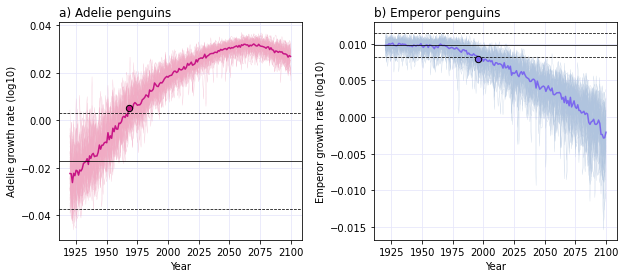

In [72]:
fig = plt.figure(figsize=(10, 4))

############# Adelies

ax = fig.add_subplot(1, 2, 1)
ax.set_title("a) Adelie penguins", loc="left", fontsize=12)

for mem in np.arange(0,50,1):

    ax.plot(adelie_dict['SIZ'].time, np.log10(adelie_dict['SIZ'].isel(sim=mem)), color=(240/255,171/255,196/255),linewidth=0.2)
    
ax.plot(adelie_dict['SIZ'].time, np.log10(adelie_dict['SIZ'].mean(dim='sim')),
           color='mediumvioletred', zorder=2)
mean = np.log10(adelie_dict['SIZ'].isel(time=slice(0,30)).mean(dim=('time','sim')).values)
std = np.log10(adelie_dict['SIZ'].isel(time=slice(0,30))).std(dim=('time','sim')).values
ax.axhline(mean, color='black',linewidth=0.75)
ax.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax.scatter(ToE_SIZ.adelie,np.log10(ToEval_SIZ.adelie),s=40,color='mediumvioletred',edgecolor='black',zorder=3)
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.set_xlabel("Year")
ax.set_ylabel("Adelie growth rate (log10)")
############# Emperor - placeholder

ax = fig.add_subplot(1, 2, 2)
ax.set_title("b) Emperor penguins", loc="left", fontsize=12)

for mem in np.arange(0,50,1):

    ax.plot(emperor_dict['SIZ'].time, np.log10(emperor_dict['SIZ'].isel(sim=mem)), color='lightsteelblue',linewidth=0.2)
    
ax.plot(emperor_dict['SIZ'].time, np.log10(emperor_dict['SIZ'].mean(dim='sim')),
           color='mediumslateblue', zorder=2)
mean = np.log10(emperor_dict['SIZ'].isel(time=slice(0,30)).mean(dim=('time','sim')).values)
std = np.log10(emperor_dict['SIZ'].isel(time=slice(0,30))).std(dim=('time','sim')).values
ax.axhline(mean, color='black',linewidth=0.75)
ax.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax.scatter(ToE_SIZ.emperor,np.log10(ToEval_SIZ.emperor),s=40,color='mediumslateblue',edgecolor='black',zorder=3)
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.set_xlabel("Year")
ax.set_ylabel("Emperor growth rate (log10)")

fig.subplots_adjust(wspace=0.3)

In [75]:
std

array(0.00079945)

In [76]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

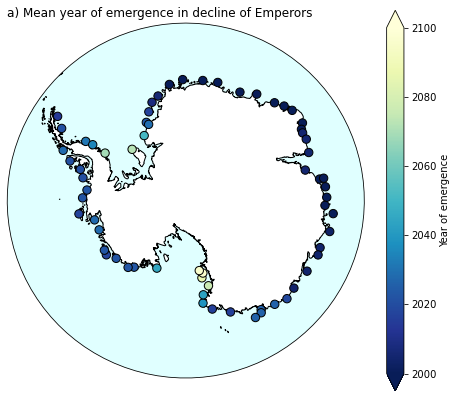

In [77]:
fig = plt.figure(figsize=(8,7))

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('a) Mean year of emergence in decline of Emperors',loc='left')
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1,zorder=1)

sc = ax.scatter(df_toe_emp.longitude,df_toe_emp.latitude, c=df_toe_emp.ToE, vmin=2000, vmax =2100, cmap='YlGnBu_r', s=70, 
                edgecolors='black', zorder=2,transform=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN, facecolor='lightcyan',zorder=0)

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cbar = fig.colorbar(sc, ax=ax,extend='both',label='Year of emergence')

In [78]:
len(df_toe_emp.latitude.values+8-df_toe_emp.latitude.values)

66

In [79]:
df_toe_emp.longitude.values[0]

-57.4445

In [80]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(name='allwhite', colors=['white'])

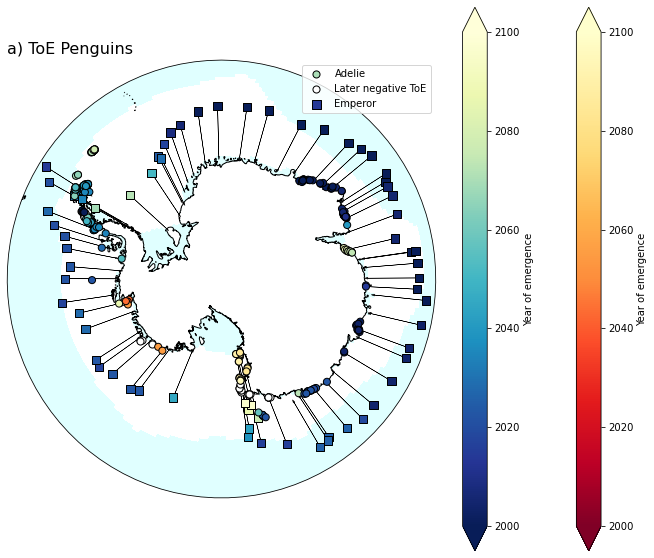

In [81]:
fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('a) ToE Penguins',loc='left',fontsize=16)
ax.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1,zorder=1)
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),
                   vmin=0,vmax=1)

sc_p = ax.scatter(df_toe_adel_positive.longitude,df_toe_adel_positive.latitude, 
                  c=df_toe_adel_positive['ToE-to-use'], vmin=2000, vmax =2100, cmap='YlOrRd_r', s=50, 
                edgecolors='black', zorder=4,transform=ccrs.PlateCarree())

sc_n = ax.scatter(df_toe_adel_negative.longitude,df_toe_adel_negative.latitude, 
                  c=df_toe_adel_negative['ToE-to-use'], vmin=2000, vmax =2100, cmap='YlGnBu_r', s=50, 
                edgecolors='black', zorder=3,transform=ccrs.PlateCarree(),label='Adelie')

sc_pn = ax.scatter(df_toe_adel_noToE.longitude,df_toe_adel_noToE.latitude, 
                   color='white', edgecolor='black', zorder=2, s=50, transform=ccrs.PlateCarree(),label='Later negative ToE')


sc_emp = ax.scatter(df_toe_emp.longitude,df_toe_emp.latitude+8, c=df_toe_emp.ToE, vmin=2000, vmax =2100, 
                    cmap='YlGnBu_r', s=70, marker='s', 
                    edgecolors='black', zorder=2,transform=ccrs.PlateCarree(), label='Emperor')
# sc_emp_dots = ax.scatter(df_toe_emp.longitude,df_toe_emp.latitude, color='black', s=20, marker='s', 
#                     edgecolors='black', zorder=2,transform=ccrs.PlateCarree())

for i in np.arange(0,len(df_toe_emp.longitude.values),1):
    x1 = df_toe_emp.longitude.values[i]+0
    x2 = df_toe_emp.longitude.values[i]
    y1 = df_toe_emp.latitude.values[i]+8
    y2 = df_toe_emp.latitude.values[i]
    ax.arrow(x1, y1, x2 - x1, y2 - y1, head_width=0.7, head_length=0.5, linewidth=0.5, color='black', zorder=1,transform=ccrs.PlateCarree())



ax.add_feature(cfeature.OCEAN, facecolor='lightcyan',zorder=0)
ax.legend()
#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle
cbar = fig.colorbar(sc_p, ax=ax,extend='both',label='Year of emergence')
cbar = fig.colorbar(sc_n, ax=ax,extend='both',label='Year of emergence')

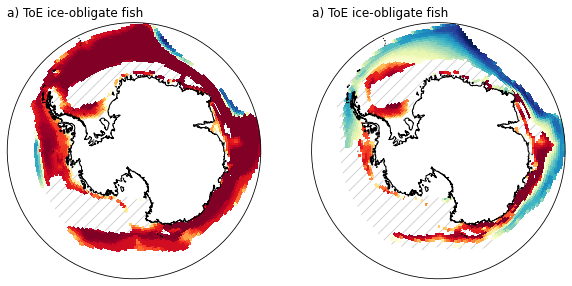

In [82]:
fig = plt.figure(figsize=(10,15))

######## ToE #################################################
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('a) ToE ice-obligate fish', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_fish.where(siz_mask==1))

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_fish.where(siz_mask==1))

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )

ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines('10m',linewidth=1,zorder=1)


ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('a) ToE ice-obligate fish', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_icefish.where(siz_mask==1))

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_icefish.where(siz_mask==1))

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )

ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines('10m',linewidth=1,zorder=1)

## old Figure 2

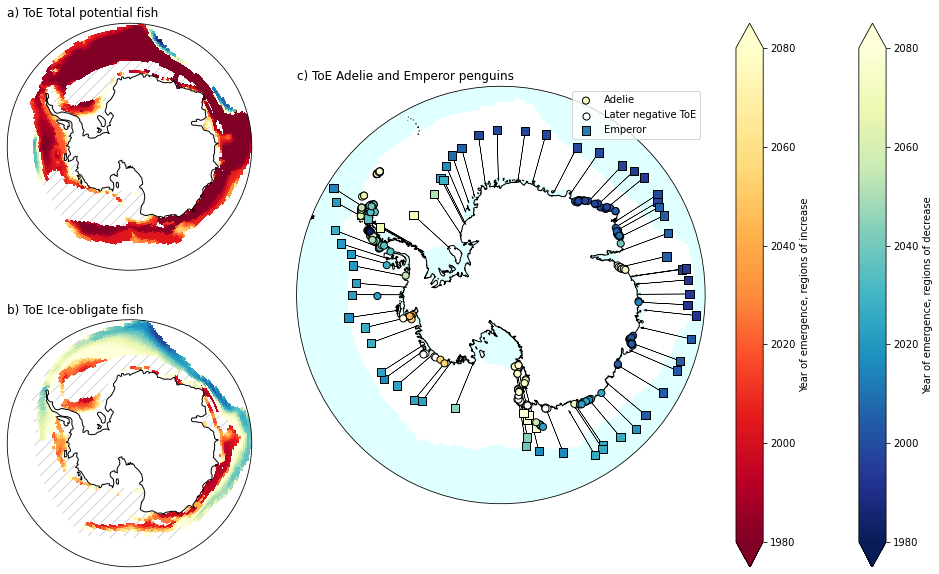

In [64]:
fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(nrows=2, ncols=5, width_ratios=(0.8, 1.2,0.08,0.1,0.08),height_ratios=(1,1))

prj =ccrs.SouthPolarStereo()

ax_map_fish = plt.subplot(gs[0, 0], projection=prj)
ax_map_ifish = plt.subplot(gs[1, 0], projection=prj)
ax_map_penguins = plt.subplot(gs[0:2, 1], projection=prj)
cb1 = plt.subplot(gs[0:2, 2])
cb2 = plt.subplot(gs[0:2, 4])

################# FISH
#### total potential fish
ax_map_fish.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_map_fish.set_title('a) ToE Total potential fish', loc='left',fontsize=12)
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_map_fish.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_fish.where(siz_mask==1))
pc1 = ax_map_fish.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2080)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_fish.where(siz_mask==1))

pc2 = ax_map_fish.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2080)
ax_map_fish.set_boundary(circle, transform=ax_map_fish.transAxes)
ax_map_fish.coastlines('110m',linewidth=1,zorder=1)

#### ice-obligate fish
ax_map_ifish.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_map_ifish.set_title('b) ToE Ice-obligate fish', loc='left',fontsize=12)
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_map_ifish.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_icefish.where(siz_mask==1))
pc1 = ax_map_ifish.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=1980,vmax=2080)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_icefish.where(siz_mask==1))

pc2 = ax_map_ifish.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=1980,vmax=2080)
ax_map_ifish.set_boundary(circle, transform=ax_map_ifish.transAxes)
ax_map_ifish.coastlines('110m',linewidth=1,zorder=1)


################ PENGUINS map

ax_map_penguins.set_title('c) ToE Adelie and Emperor penguins',loc='left',fontsize=12)
ax_map_penguins.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map_penguins.coastlines('10m',linewidth=1,zorder=1)
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
ice = ax_map_penguins.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),
                   vmin=0,vmax=1)
sc_p = ax_map_penguins.scatter(df_toe_adel_positive.longitude,df_toe_adel_positive.latitude, 
                  c=df_toe_adel_positive['ToE-to-use'], vmin=1980, vmax =2080, cmap='YlOrRd_r', s=50, 
                edgecolors='black', zorder=4,transform=ccrs.PlateCarree())

sc_n = ax_map_penguins.scatter(df_toe_adel_negative.longitude,df_toe_adel_negative.latitude, 
                  c=df_toe_adel_negative['ToE-to-use'], vmin=1980, vmax =2080, cmap='YlGnBu_r', s=50, 
                edgecolors='black', zorder=3,transform=ccrs.PlateCarree(),label='Adelie')

sc_pn = ax_map_penguins.scatter(df_toe_adel_noToE.longitude,df_toe_adel_noToE.latitude, 
                   color='white', edgecolor='black', zorder=2, s=50, transform=ccrs.PlateCarree(),label='Later negative ToE')


sc_emp = ax_map_penguins.scatter(df_toe_emp.longitude,df_toe_emp.latitude+8, c=df_toe_emp.ToE, vmin=1980, vmax =2080, 
                    cmap='YlGnBu_r', s=70, marker='s', 
                    edgecolors='black', zorder=2,transform=ccrs.PlateCarree(), label='Emperor')
# sc_emp_dots = ax.scatter(df_toe_emp.longitude,df_toe_emp.latitude, color='black', s=20, marker='s', 
#                     edgecolors='black', zorder=2,transform=ccrs.PlateCarree())

for i in np.arange(0,len(df_toe_emp.longitude.values),1):
    x1 = df_toe_emp.longitude.values[i]+0
    x2 = df_toe_emp.longitude.values[i]
    y1 = df_toe_emp.latitude.values[i]+8
    y2 = df_toe_emp.latitude.values[i]
    ax_map_penguins.arrow(x1, y1, x2 - x1, y2 - y1, head_width=0.7, head_length=0.5, linewidth=0.5, color='black', zorder=1,transform=ccrs.PlateCarree())


ax_map_penguins.add_feature(cfeature.OCEAN, facecolor='lightcyan',zorder=0)
ax_map_penguins.legend()
ax_map_penguins.set_boundary(circle, transform=ax_map_penguins.transAxes)

############### color barscbar1 = fig.colorbar(pc1, cax=cb1,extend='both',label='Year of emergence: increase')

cbar1 = fig.colorbar(pc2, cax=cb2,extend='both',label='Year of emergence, regions of decrease')

cbar1 = fig.colorbar(pc1, cax=cb1,extend='both',label='Year of emergence, regions of increase')

### New Figure 2: ToE krill and fish

In [83]:
levels = np.arange(1980,2090,10)

In [90]:
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif', size=13)

In [97]:
mean = ts_SIZ.KGP_OND.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.KGP_OND.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_kgp1 = ts_SIZ.KGP_OND['time'].where(ts_SIZ.KGP_OND.mean(dim='member_id') > mean+2*std).min(dim='time')
toe_kgp1_val = mean+2*std
print(toe_kgp1,toe_kgp1_val)

<xarray.DataArray 'time' ()>
array(2008.) 2.736267925339187


In [99]:
mean = ts_SIZ.KGP_JFM.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.KGP_JFM.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_kgp2 = ts_SIZ.KGP_JFM['time'].where(ts_SIZ.KGP_JFM.mean(dim='member_id') < mean-2*std).min(dim='time')
toe_kgp2_val = mean-2*std
print(toe_kgp2,toe_kgp2_val)

<xarray.DataArray 'time' ()>
array(2083.) 3.773950265260665


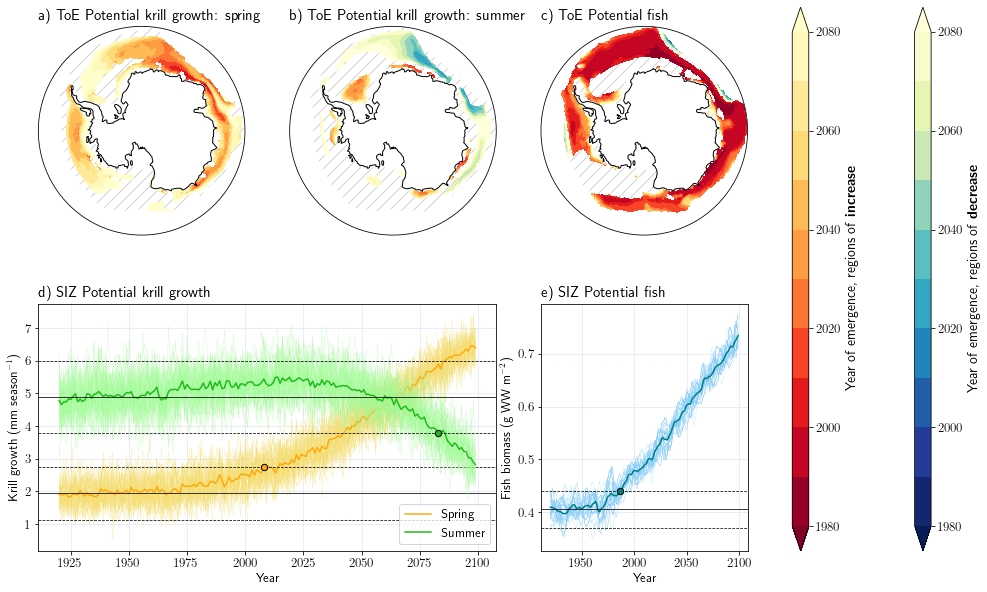

In [107]:
fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(nrows=2, ncols=6, width_ratios=(1, 1, 1,0.08,0.08,0.08),height_ratios=(1,1))

spr_color_ens = (245/255,221/255,106/255)
spr_color_mean = (252/255,170/255,16/255)

sum_color_ens = (162/255,251/255,151/255)
sum_color_mean = (32/255,188/255,26/255)

prj =ccrs.SouthPolarStereo()

ax_map_krill_spr = plt.subplot(gs[0, 0], projection=prj)
ax_map_krill_sum = plt.subplot(gs[0, 1], projection=prj)
ax_map_fish = plt.subplot(gs[0, 2], projection=prj)
ax_line_krill = plt.subplot(gs[1, 0:2])
ax_line_fish = plt.subplot(gs[1, 2])
cb1 = plt.subplot(gs[0:2, 3])
cb2 = plt.subplot(gs[0:2, 5])

################# Krill growth spring

ax_map_krill_spr.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_map_krill_spr.set_title('a) ToE Potential krill growth: spring', loc='left',fontsize=15)
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_map_krill_spr.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_kgp_ond.where(siz_mask==1))
pc1 = ax_map_krill_spr.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   levels=levels, extend='both')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_kgp_ond.where(siz_mask==1))
pc2 = ax_map_krill_spr.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both')

ax_map_krill_spr.set_boundary(circle, transform=ax_map_krill_spr.transAxes)
ax_map_krill_spr.coastlines('110m',linewidth=1,zorder=1)

################# Krill growth summer

ax_map_krill_sum.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_map_krill_sum.set_title('b) ToE Potential krill growth: summer', loc='left',fontsize=15)
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_map_krill_sum.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_kgp_jfm.where(siz_mask==1))
pc1 = ax_map_krill_sum.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   levels=levels, extend='both')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_kgp_jfm.where(siz_mask==1))
pc2 = ax_map_krill_sum.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both')

ax_map_krill_sum.set_boundary(circle, transform=ax_map_krill_sum.transAxes)
ax_map_krill_sum.coastlines('110m',linewidth=1,zorder=1)



################# FISH
#### total potential fish
ax_map_fish.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_map_fish.set_title('c) ToE Potential fish', loc='left',fontsize=15)
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_map_fish.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_fish.where(siz_mask==1))
pc1 = ax_map_fish.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   levels=levels, extend='both')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_fish.where(siz_mask==1))

pc2 = ax_map_fish.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both')

ax_map_fish.set_boundary(circle, transform=ax_map_fish.transAxes)
ax_map_fish.coastlines('110m',linewidth=1,zorder=1)

###############

cbar2 = fig.colorbar(pc2, cax=cb2,extend='both') #,label=r'Year of emergence, regions of \textbf{decrease}')
cbar2.set_label(r'Year of emergence, regions of \textbf{decrease}', size=14)

cbar1 = fig.colorbar(pc1, cax=cb1,extend='both') #,label=r'Year of emergence, regions of \textbf{increase}')
cbar1.set_label(r'Year of emergence, regions of \textbf{increase}', size=14)

############# krill line plot

ax_line_krill.set_title("d) SIZ Potential krill growth", loc="left", fontsize=15)

for mem in np.arange(0,50,1):
    ax_line_krill.plot(years, ts_SIZ['KGP_OND'].isel(member_id=mem), color=spr_color_ens,linewidth=0.2)
    
ax_line_krill.plot(years, ts_SIZ['KGP_OND'].mean(dim='member_id'),color=spr_color_mean, zorder=2,label='Spring')
mean = ts_SIZ['KGP_OND'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ['KGP_OND'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
ax_line_krill.axhline(mean, color='black',linewidth=0.75)
ax_line_krill.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_line_krill.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_line_krill.scatter(toe_kgp1,toe_kgp1_val,s=40,color=spr_color_mean,edgecolor='black',zorder=3)

for mem in np.arange(0,50,1):
    ax_line_krill.plot(years, ts_SIZ['KGP_JFM'].isel(member_id=mem), color=sum_color_ens,linewidth=0.2)
    
ax_line_krill.plot(years, ts_SIZ['KGP_JFM'].mean(dim='member_id'),color=sum_color_mean, zorder=2,label='Summer')
mean = ts_SIZ['KGP_JFM'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ['KGP_JFM'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
ax_line_krill.axhline(mean, color='black',linewidth=0.75)
ax_line_krill.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_line_krill.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_line_krill.scatter(toe_kgp2,toe_kgp2_val,s=40,color=sum_color_mean,edgecolor='black',zorder=3)
ax_line_krill.legend()
ax_line_krill.xaxis.grid(True, which='major',color='lavender')
ax_line_krill.yaxis.grid(False, which='major',color='lavender');
ax_line_krill.set_xlabel("Year")
ax_line_krill.set_ylabel("Krill growth (mm season$^{-1}$)")

#######################


############# fish line plot

ax_line_fish.set_title("e) SIZ Potential fish", loc="left", fontsize=15)
for mem in np.arange(0,50,1):
    ax_line_fish.plot(years, ts_SIZ['total_fish'].isel(member_id=mem), color='lightskyblue',linewidth=0.2)
ax_line_fish.plot(years, ts_SIZ['total_fish'].mean(dim='member_id'),
           color='teal', zorder=2)
mean = ts_SIZ['total_fish'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ['total_fish'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
ax_line_fish.axhline(mean, color='black',linewidth=0.75)
ax_line_fish.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_line_fish.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_line_fish.scatter(ToE_SIZ.total_fish,ToEval_SIZ.total_fish,s=40,color='teal',edgecolor='black',zorder=3)
ax_line_fish.xaxis.grid(True, which='major',color='lavender')
ax_line_fish.yaxis.grid(False, which='major',color='lavender');
ax_line_fish.set_xlabel("Year")
ax_line_fish.set_ylabel("Fish biomass (g WW m$^{-2}$)")
#######################

fig.subplots_adjust(wspace=0.4)

fig.savefig(f'{fig_dir}/Fig2_ToE_fish_krill.png', bbox_inches='tight', dpi=300, format='png');

## New figure 3 with just penguins

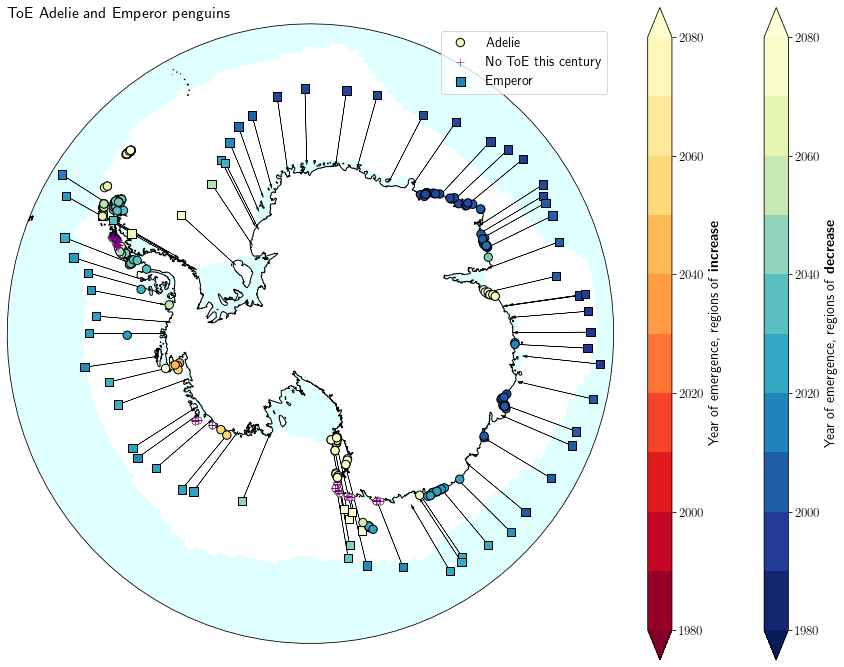

In [128]:
fig = plt.figure(figsize=(14, 12))
gs = gridspec.GridSpec(nrows=1, ncols=4, width_ratios=(1,0.04,0.04,0.04))

prj =ccrs.SouthPolarStereo()

ax_map_penguins = plt.subplot(gs[0, 0], projection=prj)

cb1 = plt.subplot(gs[0, 1])
cb2 = plt.subplot(gs[0, 3])


################ PENGUINS map

ax_map_penguins.set_title('ToE Adelie and Emperor penguins',loc='left',fontsize=16)
ax_map_penguins.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map_penguins.coastlines('10m',linewidth=1,zorder=1)
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
ice = ax_map_penguins.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),
                   vmin=0,vmax=1)
sc_p = ax_map_penguins.scatter(df_toe_adel_positive.longitude,df_toe_adel_positive.latitude, 
                  c=df_toe_adel_positive['ToE-to-use'], vmin=1980, vmax =2080, cmap='YlOrRd_r', s=70, 
                edgecolors='black', zorder=4,transform=ccrs.PlateCarree())

sc_n = ax_map_penguins.scatter(df_toe_adel_negative.longitude,df_toe_adel_negative.latitude, 
                  c=df_toe_adel_negative['ToE-to-use'], vmin=1980, vmax =2080, cmap='YlGnBu_r', s=70, 
                edgecolors='black', zorder=3,transform=ccrs.PlateCarree(),label='Adelie')

sc_pn = ax_map_penguins.scatter(df_toe_adel_noToE.longitude,df_toe_adel_noToE.latitude, 
                   color='white', edgecolor='black', linewidth=0.5, zorder=2, s=50, transform=ccrs.PlateCarree())

sc_pn = ax_map_penguins.scatter(df_toe_adel_noToE.longitude,df_toe_adel_noToE.latitude, 
                   zorder=3, marker='+', linewidth=0.5,s=50, color='darkmagenta', transform=ccrs.PlateCarree(),label='No ToE this century')

sc_emp = ax_map_penguins.scatter(df_toe_emp.longitude,df_toe_emp.latitude+8, c=df_toe_emp.ToE, vmin=1980, vmax =2080, 
                    cmap='YlGnBu_r', s=70, marker='s', 
                    edgecolors='black', zorder=2,transform=ccrs.PlateCarree(), label='Emperor')
# sc_emp_dots = ax.scatter(df_toe_emp.longitude,df_toe_emp.latitude, color='black', s=20, marker='s', 
#                     edgecolors='black', zorder=2,transform=ccrs.PlateCarree())

for i in np.arange(0,len(df_toe_emp.longitude.values),1):
    x1 = df_toe_emp.longitude.values[i]+0
    x2 = df_toe_emp.longitude.values[i]
    y1 = df_toe_emp.latitude.values[i]+8
    y2 = df_toe_emp.latitude.values[i]
    ax_map_penguins.arrow(x1, y1, x2 - x1, y2 - y1, head_width=0.7, head_length=0.5, linewidth=0.5, color='black', zorder=1,transform=ccrs.PlateCarree())


ax_map_penguins.add_feature(cfeature.OCEAN, facecolor='lightcyan',zorder=0)
ax_map_penguins.legend(fontsize=14)
ax_map_penguins.set_boundary(circle, transform=ax_map_penguins.transAxes)

############### color barscbar1 = fig.colorbar(pc1, cax=cb1,extend='both',label='Year of emergence: increase')

cbar2 = fig.colorbar(pc2, cax=cb2,extend='both') #,label=r'Year of emergence, regions of \textbf{decrease}')
cbar2.set_label(r'Year of emergence, regions of \textbf{decrease}', size=14)

cbar1 = fig.colorbar(pc1, cax=cb1,extend='both') #,label=r'Year of emergence, regions of \textbf{increase}')
cbar1.set_label(r'Year of emergence, regions of \textbf{increase}', size=14)


fig.savefig(f'{fig_dir}/Fig3_ToE_penguins.png', bbox_inches='tight', dpi=300, format='png');